In [1]:
import pandas as pd

df = pd.read_excel(r".\multiRTP（no height split）-1.xlsx")
df.head()

,NO.,H2SO4（μL）,Reacting Time（s）,Volume ratio of ethanol（%）,FL EM,RTP EM,Stokes Shift（FL）,Stokes Shift（RTP）
0,1,200,70,0.0,381,494,25,124
1,2,200,80,0.0,382,496,36,127
2,3,200,90,0.0,387,500,37,126
3,4,200,100,0.0,389,494,32,118
4,5,200,110,0.0,392,492,38,120


In [2]:
df_value = df.values

In [3]:
X = df_value[0:210, 1:4]
Y = df_value[0:210, 5]

In [4]:
print(X.shape)
print(Y.shape)

(210, 3)
(210,)


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np


def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    pr = np.corrcoef(y_true, y_pred)
    return [mse, mae, r2, pr[0][1]]

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

verbose = False
n_jobs = 4
save_csv = True

# cross validation setup
Ntrials = 6
outter_nsplit = 5

tot_count = Ntrials * outter_nsplit

# Results store
rf_result = []
xgb_result = []
dt_result = []
mlp_result = []
liner_result = []
svm_result = []

for i in range(Ntrials):
    print("when i=", i)
    kf = KFold(n_splits=5, random_state=i + 10, shuffle=True)
    for train_indices, test_indices in kf.split(X):
        x_train, x_test = X[train_indices], X[test_indices]
        y_train, y_test = Y[train_indices], Y[test_indices]
        
        # 线性回归
        liner_model = LinearRegression()
        liner_model.fit(x_train, y_train)
        y_pred = liner_model.predict(x_test)
        error = evaluate(y_test, y_pred)
        liner_result.append(error)
        
        # svm
        svm_model = SVR()
        svm_model.fit(x_train, y_train)
        y_pred = svm_model.predict(x_test)
        error = evaluate(y_test, y_pred)
        svm_result.append(error)        
        
        # RandomForestRegressor
        param_grid = {'n_estimators': [int(x) for x in np.linspace(start=30, stop=150, num=10)],
                      'min_samples_split': [20, 30, 40, 50, 60],
                      'min_samples_leaf': [3, 4, 5],
                      'max_depth': [4, 5, 6, 7, 8]}
        RF = RandomForestRegressor()
        RF_grid = GridSearchCV(RF, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=n_jobs)
        RF_grid.fit(x_train, y_train)
        y_pred = RF_grid.predict(x_test)
        # print("y_pred.shape",y_pred.shape)
        # print("y_test.shape",y_test.shape)
        error = evaluate(y_test, y_pred)
        #print("error:",error)
        rf_result.append(error)
        
        
        # xgboost
        param_grid = dict(objective=['reg:squarederror'],
                          learning_rate=[0.01],
                          n_estimators=[300, 500, 700],
                          colsample_bylevel=[0.5, 0.7, 0.9],
                          gamma=[0, 0.2],  
                          max_depth=[3, 7, 11],  
                          reg_lambda=[0.1, 1, 5, 10],  
                          subsample=[0.4, 0.7, 1])

        xgb = XGBRegressor()
        xgb_grid = GridSearchCV(xgb, param_grid=param_grid, scoring='r2', verbose=verbose, n_jobs=n_jobs)
        xgb_grid.fit(x_train, y_train)
        y_pred = xgb_grid.predict(x_test)

        error = evaluate(y_test, y_pred)
        xgb_result.append(error)

        # Decision tree
        param_prid = {'max_depth': [30, 50, 60, 100],
                      'min_impurity_decrease': [0.1, 0.2, 0.5]}
        dt = DecisionTreeRegressor()
        dt_grid = GridSearchCV(dt, param_grid=param_prid, n_jobs=n_jobs, verbose=verbose)
        dt_grid.fit(x_train, y_train)
        y_pred = dt_grid.predict(x_test)
        error = evaluate(y_test, y_pred)
        dt_result.append(error)

        # MLP
        mlp_clf = Pipeline([
            ('sc', StandardScaler()),
            ('reg', MLPRegressor())
        ])
        tuned_parameters = dict(
            reg__hidden_layer_sizes=[[5], [10], [20], [5, 5], [10, 10], [20, 20], [5, 5, 5], [10, 10, 10],
                                     [20, 20, 20]],
            reg__alpha=[1e-4, 1e-3, 1e-2, 1e-1, 1],  #L2 penalty (regularization term) parameter.
            reg__early_stopping=[True],
            reg__solver=['lbfgs'])
        mlp_cv = GridSearchCV(mlp_clf, tuned_parameters, scoring='r2', verbose=verbose, n_jobs=n_jobs)
        mlp_cv.fit(x_train, y_train)
        y_pred = mlp_cv.predict(x_test)
        error = evaluate(y_test, y_pred)
        mlp_result.append(error)

when i= 0


C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: Conv

when i= 1


C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: Conv

when i= 2


C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


when i= 3


C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: Conv

when i= 4


C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


when i= 5


C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Administrator\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [12]:
# 将所有的评价指标保存为csv并进行输出
r2_result = {'liner': [], 'svm': [], 'rf': [], 'xgb': [], 'dt': [], 'mlp': []}
mse_result = {'liner': [], 'svm': [], 'rf': [], 'xgb': [], 'dt': [], 'mlp': []}
mae_result = {'liner': [], 'svm': [], 'rf': [], 'xgb': [], 'dt': [], 'mlp': []}
pr_result = {'liner': [], 'svm': [], 'rf': [], 'xgb': [], 'dt': [], 'mlp': []}

for i, key in zip([liner_result, svm_result, rf_result, xgb_result, dt_result, mlp_result], list(r2_result.keys())):
    for j in i:
        r2_result[key].append(j[2])
        mse_result[key].append(j[0])
        mae_result[key].append(j[1])
        pr_result[key].append(j[3])

In [32]:
r2_result = pd.DataFrame(r2_result)
r2_result.to_csv('./out/r2_result.csv')
pd.DataFrame(mse_result).to_csv('./out/mse_result.csv')
pd.DataFrame(mae_result).to_csv('./out/mae_result.csv')
pd.DataFrame(pr_result).to_csv('./out/pr_result.csv')

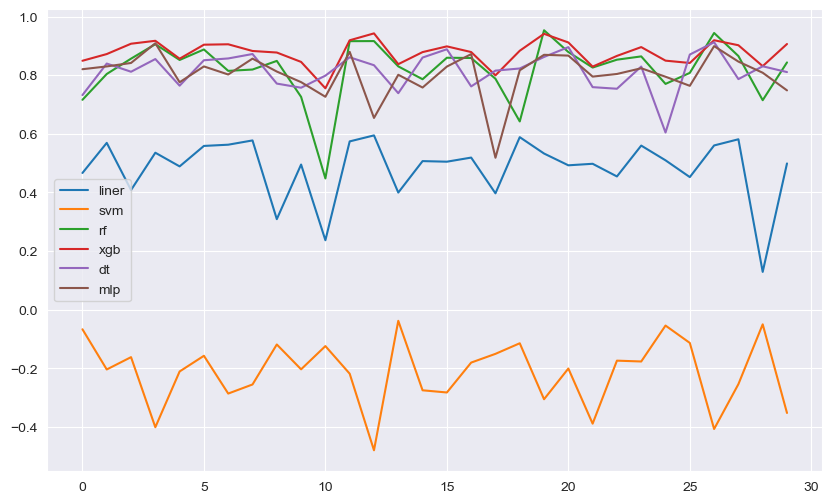

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(r2_result['liner'], label='liner')
plt.plot(r2_result['svm'], label='svm')
plt.plot(r2_result['rf'], label='rf')
plt.plot(r2_result['xgb'], label='xgb')
plt.plot(r2_result['dt'], label='dt')
plt.plot(r2_result['mlp'], label='mlp')

plt.legend()
plt.savefig('r2_result.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
from sklearn.tree import export_graphviz
import graphviz

rf = RF_grid.best_estimator_
# 导出随机森林中的第一棵树
tree = rf.estimators_[0]

# 将树导出为dot文件
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=['H2SO4(μL)', 'Reacting Time(s)', 'Volume ratio of ethanol(%)'], 
                           filled=True, rounded=True, 
                           special_characters=True)

# 使用graphviz将dot文件转换为图像
graph = graphviz.Source(dot_data) 
graph.render("random_forest_tree")  # 保存为文件 random_forest_tree.pdf

'random_forest_tree.pdf'